In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from myutils import (
    get_expanding_kelly, get_rolling_kelly,
)

In [49]:
kospi = pd.read_csv('KOSPI200.csv')
kospi = kospi.iloc[::-1].reset_index(drop=True)
kospi = kospi.set_index('Date')
kospi['Change %'] = kospi['Change %'].str.replace('%', '').astype(float)

sp500 = pd.read_csv('SP500_mine.csv')
sp500 = sp500.iloc[::-1].reset_index(drop=True)
sp500 = sp500.set_index('Date')
sp500['Price'] = sp500['Price'].str.replace(',', '').astype(float)
sp500['Open'] = sp500['Open'].str.replace(',', '').astype(float)
sp500['High'] = sp500['High'].str.replace(',', '').astype(float)
sp500['Low'] = sp500['Low'].str.replace(',', '').astype(float)
sp500['Change %'] = sp500['Change %'].str.replace('%', '').astype(float)

returns_kospi = kospi['Price'].pct_change()
shift_returns_kospi = returns_kospi.shift(-1)

returns_sp500 = sp500['Price'].pct_change()
shift_returns_sp500 = returns_sp500.shift(-1)

In [50]:
kospi['rf'] = 0.02
sp500['rf'] = 0.02

In [51]:
rolling_kelly = get_rolling_kelly(kospi['Change %'])
kospi['kelly'] = rolling_kelly

rolling_kelly = get_rolling_kelly(sp500['Change %'])
sp500['kelly'] = rolling_kelly

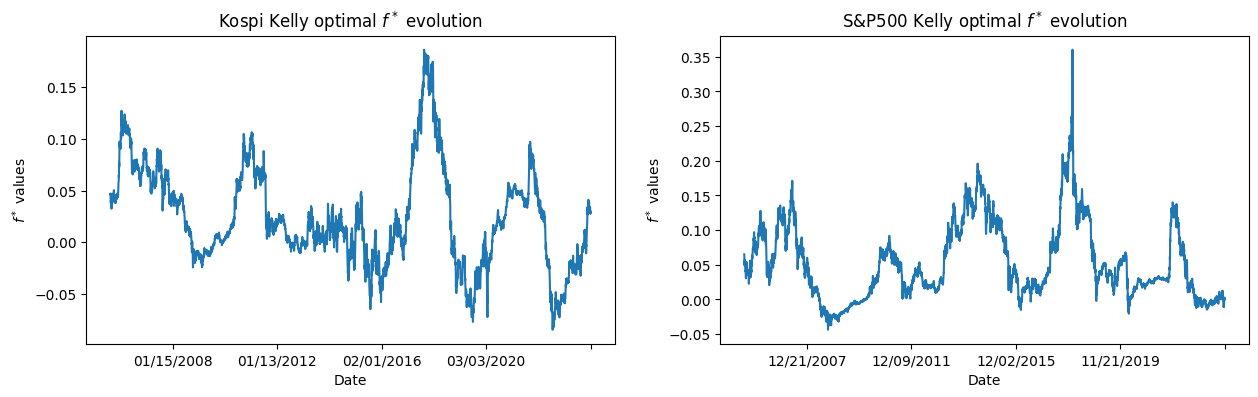

In [52]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

kospi['kelly'].plot(ax=ax[0])
ax[0].set_ylabel('$f^*$ values');
ax[0].set_title('Kospi Kelly optimal $f^*$ evolution');

sp500['kelly'].plot(ax=ax[1])
ax[1].set_ylabel('$f^*$ values');
ax[1].set_title('S&P500 Kelly optimal $f^*$ evolution');

In [53]:
kospi.head(500)

,Price,Open,High,Low,Vol.,Change %,rf,kelly
Date,,,,,,,,
01/02/2004,106.65,105.90,106.77,105.63,152.34M,1.37,0.02,NaN
01/05/2004,107.07,106.01,107.23,105.96,156.85M,0.39,0.02,NaN
01/06/2004,106.90,108.02,108.02,106.41,222.60M,-0.16,0.02,NaN
01/07/2004,107.54,107.29,108.02,107.15,181.06M,0.60,0.02,NaN
01/08/2004,107.20,108.14,109.31,107.20,234.06M,-0.32,0.02,NaN
...,...,...,...,...,...,...,...,...
12/27/2005,177.20,176.77,177.53,176.57,130.78M,0.53,0.02,0.095644
12/28/2005,176.16,174.94,176.36,174.39,129.94M,-0.59,0.02,0.091446
12/29/2005,177.43,176.55,177.96,176.25,154.95M,0.72,0.02,0.090197


In [54]:
kospi['daily_return'] = kospi['kelly']/100 * kospi['Change %'] + (1-kospi['kelly']/100) * kospi['rf']

In [55]:
kospi['daily_return'] 

Date
01/02/2004         NaN
01/05/2004         NaN
01/06/2004         NaN
01/07/2004         NaN
01/08/2004         NaN
                ...   
03/14/2024    0.020329
03/15/2024    0.019440
03/18/2024    0.020149
03/19/2024    0.019690
03/20/2024    0.020493
Name: daily_return, Length: 5000, dtype: float64

In [56]:
kospi_new = kospi.dropna()

In [154]:
rebalancing_interval = 100
v0 = 100 # 100만원

portfolio = np.zeros(len(kospi_new))
equity = np.zeros(len(kospi_new))
cash = np.zeros(len(kospi_new))

for i, _row in enumerate(kospi_new.iterrows()):
    row = _row[1]
    # print(row)
    if i == 0:
        # portfolio[0] = 1
        # cash[0] = 1
        # equity[0] = 0
        portfolio[0] = v0
        cash[0] = v0*(1-row['kelly'])
        equity[0] = v0*row['kelly']
    else:
        portfolio[i] = cash[i-1] + equity[i-1]
        if i % rebalancing_interval == 0:
            equity[i] = portfolio[i] * row['kelly']
            cash[i] = portfolio[i] * (1 - row['kelly'])
        else:
            equity[i] = equity[i-1] * (1+row['Change %'])
            cash[i] = cash[i-1] * (1+row['rf'])

In [145]:
rebalancing_interval = 100
v0 = 100 # 100원

portfolio = np.zeros(len(kospi_new))
equity = np.zeros(len(kospi_new))
cash = np.zeros(len(kospi_new))

for i, _row in enumerate(kospi_new.iterrows()):
    row = _row[1]
    # print(row)
    if i == 0:
        # portfolio[0] = 1
        # cash[0] = 1
        # equity[0] = 0
        portfolio[0] = 1
        cash[0] = (1-row['kelly'])
        equity[0] = row['kelly']
    else:
        portfolio[i] = cash[i-1] + equity[i-1]
        if i % rebalancing_interval == 0:
            equity[i] = portfolio[i] * row['kelly']
            cash[i] = portfolio[i] * (1 - row['kelly'])
        else:
            equity[i] = equity[i-1] * (1+row['Change %'])
            cash[i] = cash[i-1] * (1+row['rf'])

In [155]:
# kospi_new['log_returns'] = np.log(kospi_new["Change %"])

kospi_new.loc[:, 'portfolio'] = portfolio
kospi_new.loc[:, 'equity'] = equity
kospi_new.loc[:, 'cash'] = cash
# kospi_new['strategy_returns'] = kospi_new['portfolio'] / kospi_new['portfolio'].shift(1)
# kospi_new['strategy_log_returns'] = np.log(kospi_new['strategy_returns'])
# kospi_new['strategy_cum_returns'] = kospi_new['strategy_log_returns'].cumsum()
# kospi_new['cum_returns'] = kospi_new['log_returns'].cumsum()

In [156]:
kospi_new.head(4)

,Price,Open,High,Low,Vol.,Change %,rf,kelly,daily_return,log_returns,portfolio,equity,cash,strategy_returns,strategy_log_returns,strategy_cum_returns,cum_returns
Date,,,,,,,,,,,,,,,,,
08/10/2005,142.70,142.59,144.02,142.07,132.84M,0.42,0.02,0.046445,0.020186,-0.867501,100.000000,4.644494,95.355506,NaN,NaN,NaN,-0.867501
08/11/2005,145.35,142.64,145.35,142.61,131.33M,1.86,0.02,0.047015,0.020865,0.620576,100.000000,13.283254,97.262616,1.000000,0.000000,0.000000,-0.246924
08/12/2005,146.04,145.75,146.25,144.81,136.81M,0.47,0.02,0.047120,0.020212,-0.755023,110.545869,19.526383,99.207868,1.105459,0.100260,0.100260,-1.001947
08/16/2005,144.30,146.26,147.11,144.17,132.22M,-1.19,0.02,0.045626,0.019448,NaN,118.734251,-3.710013,101.192026,1.074072,0.071457,0.171718,NaN


<Axes: xlabel='Date'>

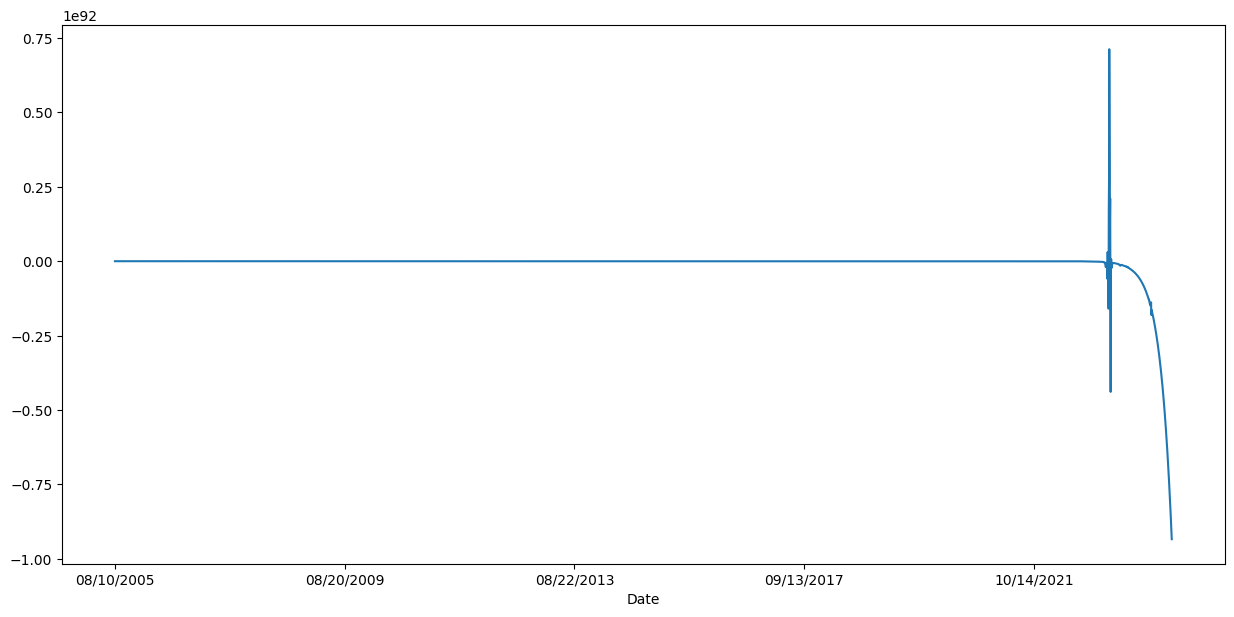

In [157]:
kospi_new['portfolio'].plot(figsize=(15, 7))

<Axes: xlabel='Date'>

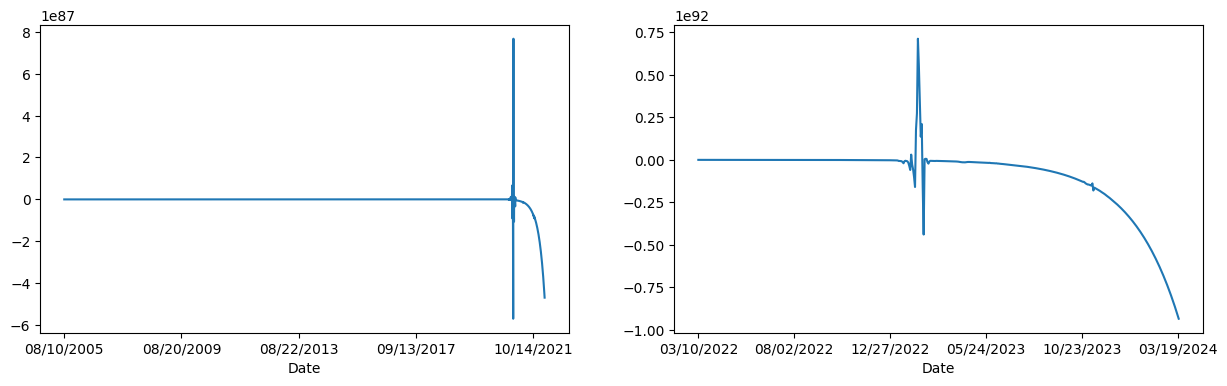

In [158]:
split_date = '03/10/2022'
before = kospi_new.loc[:split_date]
after = kospi_new.loc[split_date:]


fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

before['portfolio'].plot(ax=ax[0])

after['portfolio'].plot(ax=ax[1])